In [ ]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [ ]:
device = 'cuda'

In [ ]:
train_data = np.loadtxt(r"D:\ecg\mitbih_train.csv", delimiter=',')
test_data = np.loadtxt(r"D:\ecg\mitbih_test.csv", delimiter=',')

In [ ]:
train_data[0]

array([0.97794116, 0.92647058, 0.68137252, 0.24509804, 0.15441176,
       0.19117647, 0.15196079, 0.08578432, 0.05882353, 0.04901961,
       0.04411765, 0.06127451, 0.06617647, 0.06127451, 0.04901961,
       0.07352941, 0.06127451, 0.06127451, 0.06617647, 0.06862745,
       0.09558824, 0.0759804 , 0.09313726, 0.10539216, 0.11519608,
       0.10294118, 0.11764706, 0.125     , 0.14215687, 0.12745099,
       0.15196079, 0.14460784, 0.16421568, 0.14460784, 0.15931372,
       0.15196079, 0.15441176, 0.14215687, 0.15196079, 0.15196079,
       0.14705883, 0.13235295, 0.12745099, 0.13480392, 0.13725491,
       0.1127451 , 0.10784314, 0.10539216, 0.10784314, 0.09803922,
       0.09313726, 0.10294118, 0.1004902 , 0.10539216, 0.10294118,
       0.11764706, 0.10539216, 0.12254902, 0.12745099, 0.14215687,
       0.14705883, 0.14460784, 0.1740196 , 0.23039216, 0.23774509,
       0.24754901, 0.23039216, 0.2254902 , 0.19852941, 0.17647059,
       0.13235295, 0.125     , 0.11764706, 0.12254902, 0.11274

In [ ]:
class EcgDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        np_ecg = self.data[idx][:-1]
        ecg = torch.from_numpy(np_ecg).to(torch.float32)
        np_label = self.data[idx][-1]
        label = torch.tensor(np_label, dtype=torch.float32)
        ecg = ecg.unsqueeze(1)  # Add channel dimension if missing
        ecg = ecg.permute(1, 0)  # Change shape to (batch_size, channels, seq_length)

        return ecg, int(label)

In [ ]:
train_dataset = EcgDataset(data=train_data)
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)

test_dataset = EcgDataset(data=test_data)
test_dataloader = DataLoader(test_dataset, batch_size=500, shuffle=True)

In [ ]:
ecg, label = next(iter(test_dataloader))

In [ ]:
ecg.shape

torch.Size([500, 1, 187])

In [ ]:
# Setting up the training step and testing step
def train_step(model, optimizer, loss_fn, epoch, dataloader):
  model.train()
  train_loss, acc = 0, 0
  total_correct = 0
  total_samples = 0

  for X, y in dataloader:
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss +=loss.item()
    model.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    total_correct += (y_pred_class == y).sum().item()
    total_samples += y.size(0)

  acc = total_correct * 100 / total_samples

  train_loss = train_loss/len(dataloader)
  print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc:2f}")


def test_step(model, loss_fn, epoch, dataloader):
  model.eval()
  test_loss, acc = 0, 0
  total_correct = 0
  total_samples = 0


  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      total_correct += (y_pred_class == y).sum().item()
      total_samples += y.size(0)

    acc = total_correct * 100 / total_samples

    test_loss = test_loss/len(dataloader)
    print(f"Epoch: {epoch} | Test Loss: {loss} | Accuracy: {acc:2f}")
    print("************************")

In [ ]:
class Simple1DCNN(nn.Module):
    def __init__(self, input_channels, num_classes, sequence_length):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Compute the output size after convolutions and pooling
        self._to_linear = self._compute_flattened_size(input_channels, sequence_length)

        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def _compute_flattened_size(self, input_channels, sequence_length):
        x = torch.randn(1, input_channels, sequence_length)  # Dummy tensor
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        return x.numel()  # Total number of features after conv and pooling

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
sequence_length = 187
model = Simple1DCNN(input_channels=1, num_classes=5, sequence_length=sequence_length).to(device)

In [ ]:
model(ecg.to(device)).argmax(dim=1)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
# Setting up optimizer and loss function
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
# Training the model
epochs = 50
torch.manual_seed(42)
torch.cuda.manual_seed(42)
for epoch in range(epochs):
  train_step(model=model,
             optimizer=optimizer,
             loss_fn=loss_fn,
             epoch=epoch,
             dataloader=train_dataloader)
  test_step(model=model,
            loss_fn=loss_fn,
            epoch=epoch,
            dataloader=test_dataloader)

Epoch: 0 | Loss: 0.11626824736595154 | Accuracy: 90.466455
Epoch: 0 | Test Loss: 0.17221419513225555 | Accuracy: 94.651014
************************
Epoch: 1 | Loss: 0.045615702867507935 | Accuracy: 95.770610
Epoch: 1 | Test Loss: 0.1677989363670349 | Accuracy: 95.961995
************************
Epoch: 2 | Loss: 0.07448151707649231 | Accuracy: 96.476460
Epoch: 2 | Test Loss: 0.18204337358474731 | Accuracy: 96.564955
************************
Epoch: 3 | Loss: 0.12079643458127975 | Accuracy: 96.999566
Epoch: 3 | Test Loss: 0.1891753077507019 | Accuracy: 96.925818
************************
Epoch: 4 | Loss: 0.11989246308803558 | Accuracy: 97.311374
Epoch: 4 | Test Loss: 0.11778265982866287 | Accuracy: 96.875571
************************
Epoch: 5 | Loss: 0.09435677528381348 | Accuracy: 97.502113
Epoch: 5 | Test Loss: 0.09509772062301636 | Accuracy: 97.300384
************************
Epoch: 6 | Loss: 0.03618132323026657 | Accuracy: 97.719122
Epoch: 6 | Test Loss: 0.09244558960199356 | Accuracy: 

KeyboardInterrupt: 

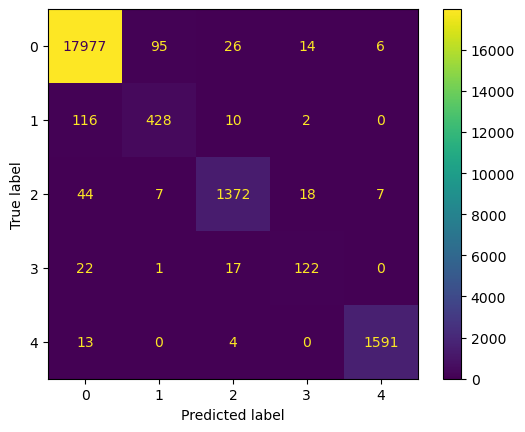

In [ ]:
# Plotting Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_true = []
y_preds = []

model.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)


    y_pred = model(X)
    y_pred_class = y_pred.argmax(dim=1)

    y_true.extend(y.cpu().numpy())
    y_preds.extend(y_pred_class.cpu().numpy())

cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(5))
disp.plot(cmap="viridis")  # Customize colormap if needed

In [ ]:
torch.save(obj=model.state_dict(),
           f=r"C:\Users\shobh\Desktop\python\ecg.pth")

In [ ]:
model.load_state_dict(torch.load(r"C:\Users\shobh\Desktop\python\ecg.pth"))

C:\Users\shobh\AppData\Local\Temp\ipykernel_12940\2791013023.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\Users\shobh\Desktop\py

<All keys matched successfully>

In [ ]:
mylist = '''0.97794116, 0.92647058, 0.68137252, 0.24509804, 0.15441176,
       0.19117647, 0.15196079, 0.08578432, 0.05882353, 0.04901961,
       0.04411765, 0.06127451, 0.06617647, 0.06127451, 0.04901961,
       0.07352941, 0.06127451, 0.06127451, 0.06617647, 0.06862745,
       0.09558824, 0.0759804 , 0.09313726, 0.10539216, 0.11519608,
       0.10294118, 0.11764706, 0.125     , 0.14215687, 0.12745099,
       0.15196079, 0.14460784, 0.16421568, 0.14460784, 0.15931372,
       0.15196079, 0.15441176, 0.14215687, 0.15196079, 0.15196079,
       0.14705883, 0.13235295, 0.12745099, 0.13480392, 0.13725491,
       0.1127451 , 0.10784314, 0.10539216, 0.10784314, 0.09803922,
       0.09313726, 0.10294118, 0.1004902 , 0.10539216, 0.10294118,
       0.11764706, 0.10539216, 0.12254902, 0.12745099, 0.14215687,
       0.14705883, 0.14460784, 0.1740196 , 0.23039216, 0.23774509,
       0.24754901, 0.23039216, 0.2254902 , 0.19852941, 0.17647059,
       0.13235295, 0.125     , 0.11764706, 0.12254902, 0.1127451 ,
       0.12990196, 0.11519608, 0.08333334, 0.        , 0.06617647,
       0.30637255, 0.61274511, 0.8602941 , 1.        , 0.95833331,
       0.74509805, 0.30392158, 0.16421568, 0.20588236, 0.16421568,
       0.10294118, 0.09558824, 0.09068628, 0.1004902 , 0.09558824,
       0.09803922, 0.09313726, 0.09803922, 0.09558824, 0.1127451 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.       '''.split()

In [ ]:
''.join(mylist)

'0.97794116,0.92647058,0.68137252,0.24509804,0.15441176,0.19117647,0.15196079,0.08578432,0.05882353,0.04901961,0.04411765,0.06127451,0.06617647,0.06127451,0.04901961,0.07352941,0.06127451,0.06127451,0.06617647,0.06862745,0.09558824,0.0759804,0.09313726,0.10539216,0.11519608,0.10294118,0.11764706,0.125,0.14215687,0.12745099,0.15196079,0.14460784,0.16421568,0.14460784,0.15931372,0.15196079,0.15441176,0.14215687,0.15196079,0.15196079,0.14705883,0.13235295,0.12745099,0.13480392,0.13725491,0.1127451,0.10784314,0.10539216,0.10784314,0.09803922,0.09313726,0.10294118,0.1004902,0.10539216,0.10294118,0.11764706,0.10539216,0.12254902,0.12745099,0.14215687,0.14705883,0.14460784,0.1740196,0.23039216,0.23774509,0.24754901,0.23039216,0.2254902,0.19852941,0.17647059,0.13235295,0.125,0.11764706,0.12254902,0.1127451,0.12990196,0.11519608,0.08333334,0.,0.06617647,0.30637255,0.61274511,0.8602941,1.,0.95833331,0.74509805,0.30392158,0.16421568,0.20588236,0.16421568,0.10294118,0.09558824,0.09068628,0.1004902

In [ ]:
mystr = np.str_("0.97794116,0.92647058,0.68137252,0.24509804,0.15441176,0.19117647,0.15196079,0.08578432,0.05882353,0.04901961,0.04411765,0.06127451,0.06617647,0.06127451,0.04901961,0.07352941,0.06127451,0.06127451,0.06617647,0.06862745,0.09558824,0.0759804,0.09313726,0.10539216,0.11519608,0.10294118,0.11764706,0.125,0.14215687,0.12745099,0.15196079,0.14460784,0.16421568,0.14460784,0.15931372,0.15196079,0.15441176,0.14215687,0.15196079,0.15196079,0.14705883,0.13235295,0.12745099,0.13480392,0.13725491,0.1127451,0.10784314,0.10539216,0.10784314,0.09803922,0.09313726,0.10294118,0.1004902,0.10539216,0.10294118,0.11764706,0.10539216,0.12254902,0.12745099,0.14215687,0.14705883,0.14460784,0.1740196,0.23039216,0.23774509,0.24754901,0.23039216,0.2254902,0.19852941,0.17647059,0.13235295,0.125,0.11764706,0.12254902,0.1127451,0.12990196,0.11519608,0.08333334,0.,0.06617647,0.30637255,0.61274511,0.8602941,1.,0.95833331,0.74509805,0.30392158,0.16421568,0.20588236,0.16421568,0.10294118,0.09558824,0.09068628,0.1004902,0.09558824,0.09803922,0.09313726,0.09803922,0.09558824,0.1127451,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.")

In [ ]:
torch.from_numpy(np.array(mystr.split(','), dtype=np.float32)).unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 188])

In [ ]:
0.97794116,0.92647058,0.68137252,0.24509804,0.15441176,0.19117647,0.15196079,0.08578432,0.05882353,0.04901961,0.04411765,0.06127451,0.06617647,0.06127451,0.04901961,0.07352941,0.06127451,0.06127451,0.06617647,0.06862745,0.09558824,0.0759804,0.09313726,0.10539216,0.11519608,0.10294118,0.11764706,0.125,0.14215687,0.12745099,0.15196079,0.14460784,0.16421568,0.14460784,0.15931372,0.15196079,0.15441176,0.14215687,0.15196079,0.15196079,0.14705883,0.13235295,0.12745099,0.13480392,0.13725491,0.1127451,0.10784314,0.10539216,0.10784314,0.09803922,0.09313726,0.10294118,0.1004902,0.10539216,0.10294118,0.11764706,0.10539216,0.12254902,0.12745099,0.14215687,0.14705883,0.14460784,0.1740196,0.23039216,0.23774509,0.24754901,0.23039216,0.2254902,0.19852941,0.17647059,0.13235295,0.125,0.11764706,0.12254902,0.1127451,0.12990196,0.11519608,0.08333334,0.,0.06617647,0.30637255,0.61274511,0.8602941,1.,0.95833331,0.74509805,0.30392158,0.16421568,0.20588236,0.16421568,0.10294118,0.09558824,0.09068628,0.1004902,0.09558824,0.09803922,0.09313726,0.09803922,0.09558824,0.1127451,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.

187